In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from hyperopt import hp, tpe
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif, SelectKBest

from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('AB_NYC_2019.csv',delimiter = ',')

# **Exploratory Data Analysis & Feature Creation**

 **dealing with missing value and outlier**

In [3]:
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
# check missing values
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
# Check if all rows with NaN value in 'last_review' contains value 0 in 'number_of_reviews'
matching_rows_df = df[(df['number_of_reviews'] == 0) & (df['last_review'].isnull())]
if len(matching_rows_df) == df['last_review'].isnull().sum():
    print("All NaN rows in 'last_review' have the corresponding value 0 in the 'number_of_reviews'")
else:
    print("There are NaN rows without the corresponding value in the 'number_of_reviews'")

All NaN rows in 'last_review' have the corresponding value 0 in the 'number_of_reviews'


count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_12849/1827350110.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

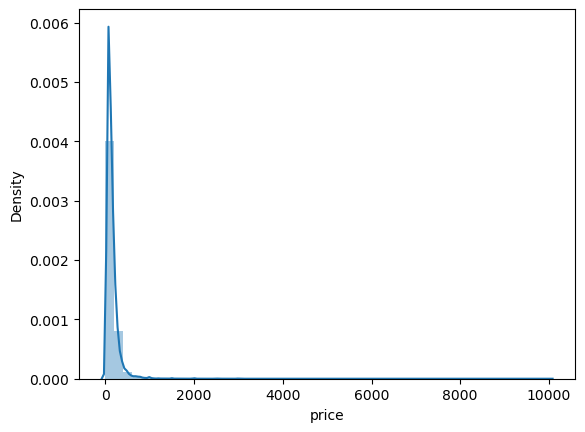

In [7]:
print(df['price'].describe())
sns.distplot(df['price'])

In [8]:
# drop the rows with price equaling to 0
df1 = df[df['price'] != 0]
df1.reset_index(drop=True, inplace=True)


#drop the rows with price higher than the 95% quantile to reduce the impact of outliers.
print(df['price'].quantile(0.95))
print((df1['price'] >= df['price'].quantile(0.95)).sum())
df1 = df1[df1['price'] <= df['price'].quantile(0.95)]
df1.reset_index(drop=True, inplace=True)

df1.info()

355.0
2451
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46443 entries, 0 to 46442
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              46443 non-null  int64  
 1   name                            46428 non-null  object 
 2   host_id                         46443 non-null  int64  
 3   host_name                       46422 non-null  object 
 4   neighbourhood_group             46443 non-null  object 
 5   neighbourhood                   46443 non-null  object 
 6   latitude                        46443 non-null  float64
 7   longitude                       46443 non-null  float64
 8   room_type                       46443 non-null  object 
 9   price                           46443 non-null  int64  
 10  minimum_nights                  46443 non-null  int64  
 11  number_of_reviews               46443 non-null  int64  
 12  last_review          

In [9]:
# to assignment values to missing ones.
df1['last_review'] = df1['last_review'].fillna('2020-01-01')
avg_value = df['reviews_per_month'].mean()
df1['reviews_per_month'] = df1['reviews_per_month'].fillna(avg_value)
df1.isna().sum()

id                                 0
name                              15
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [10]:
df1.describe()

id       host_id      latitude     longitude         price  \
count  4.644300e+04  4.644300e+04  46443.000000  46443.000000  46443.000000   
mean   1.891941e+07  6.646223e+07     40.728576    -73.950978    122.612794   
std    1.093144e+07  7.769824e+07      0.055187      0.046383     71.971323   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420     10.000000   
25%    9.445547e+06  7.719674e+06     40.689360    -73.982100     65.000000   
50%    1.954585e+07  3.034546e+07     40.722020    -73.954580    100.000000   
75%    2.893970e+07  1.056556e+08     40.763330    -73.934630    160.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990    355.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    46443.000000       46443.000000       46443.000000   
mean         6.944297          23.823009           1.376519   
std         19.875539          45.184378           1.513928   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.270000   
50%          2.000000           5.000000           1.190000   
75%          5.000000          24.000000           1.610000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    46443.000000      46443.000000  
mean                         6.686627        109.706264  
std                         31.131876        130.423905  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         40.000000  
75%                          2.000000        218.000000  
max                        327.000000        365.000000

In [11]:
# split data into Numerical data & Categorical data
def split_num_cat(data):
    num_data = data.select_dtypes(exclude=['object'])
    cat_data = data.select_dtypes(include=['object'])
    return num_data, cat_data

num, cat = split_num_cat(df1)
print(num.columns)
print(cat.columns)

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'last_review'],
      dtype='object')


 **numerical variables**

In [12]:
# transfer the original price into log value.
df1['price_log'] = np.log10(df1['price'])

/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_12849/265618623.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[col], ax=axes[i])
/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_12849/265618623.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[col], ax=axes[i]

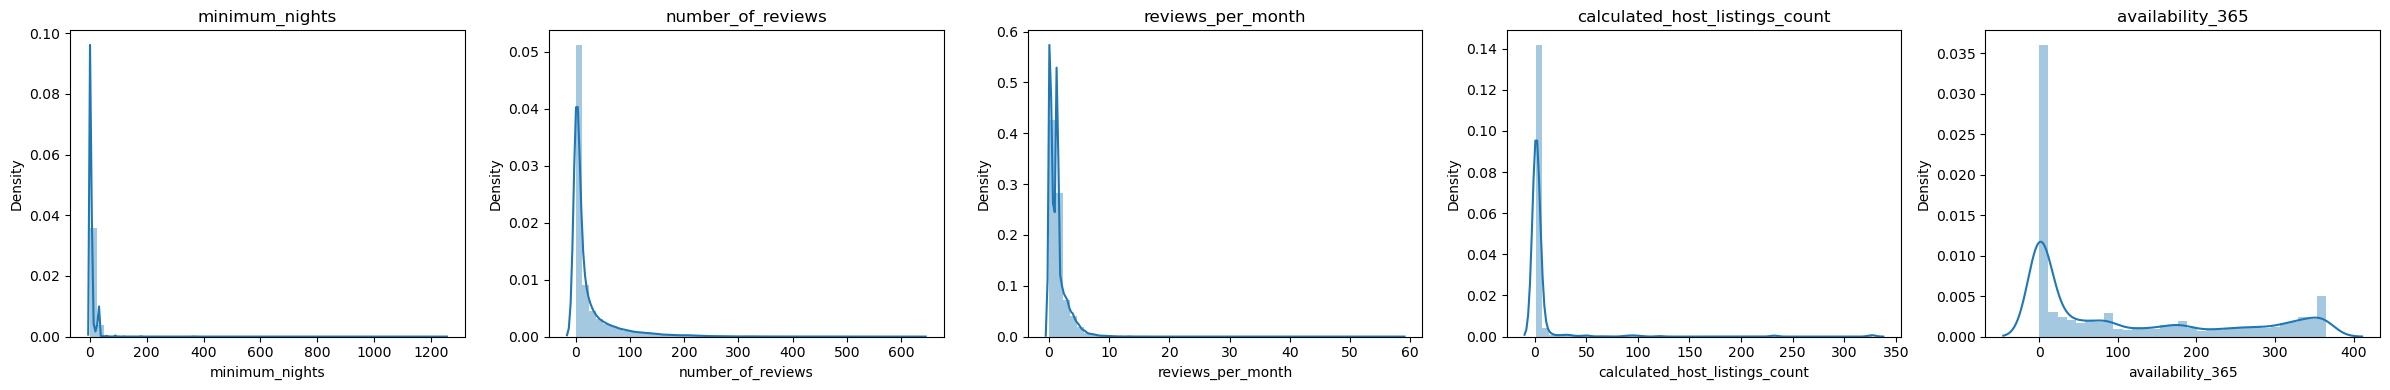

minimum_nights  number_of_reviews  reviews_per_month  \
count    46443.000000       46443.000000       46443.000000   
mean         6.944297          23.823009           1.376519   
std         19.875539          45.184378           1.513928   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.270000   
50%          2.000000           5.000000           1.190000   
75%          5.000000          24.000000           1.610000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    46443.000000      46443.000000  
mean                         6.686627        109.706264  
std                         31.131876        130.423905  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         40.000000  
75%                          2.000000        218.000000  
max                        327.000000        365.000000

In [13]:
# check the distribution of each numerical feature
cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(24, 4))
for i, col in enumerate(cols):
    sns.distplot(df1[col], ax=axes[i])
    axes[i].set_title(col)
# Show the plot
plt.tight_layout()
plt.show()

df1[cols].describe()

In [14]:
print(df1['calculated_host_listings_count'].quantile(0.95))
print((df1['calculated_host_listings_count']>df1['calculated_host_listings_count'].quantile(0.95)).sum())
print(df1['reviews_per_month'].quantile(0.95))
print((df1['reviews_per_month']>df1['reviews_per_month'].quantile(0.95)).sum())

13.0
2315
4.35
2315


In [15]:
# add a columns to reduce the impact of outliers in 'calculated_host_listings_count'
df1['adj_calculated_host_listings_count'] = np.where(df1['calculated_host_listings_count'] > df1['calculated_host_listings_count'].quantile(0.95),\
                                        df1['calculated_host_listings_count'].quantile(0.95), df1['calculated_host_listings_count'])
df1['adj_reviews_per_month'] = np.where(df1['reviews_per_month'] > df1['reviews_per_month'].quantile(0.95),\
                                        df1['reviews_per_month'].quantile(0.95), df1['reviews_per_month'])


In [16]:
# add a column showing the frequency of the host_id across all rows
df1.host_id = df1.host_id.astype(str)
# get value counts for the 'color' feature
counts = df1.host_id.value_counts()
df1['host_id_count'] = df1['host_id'].map(counts)


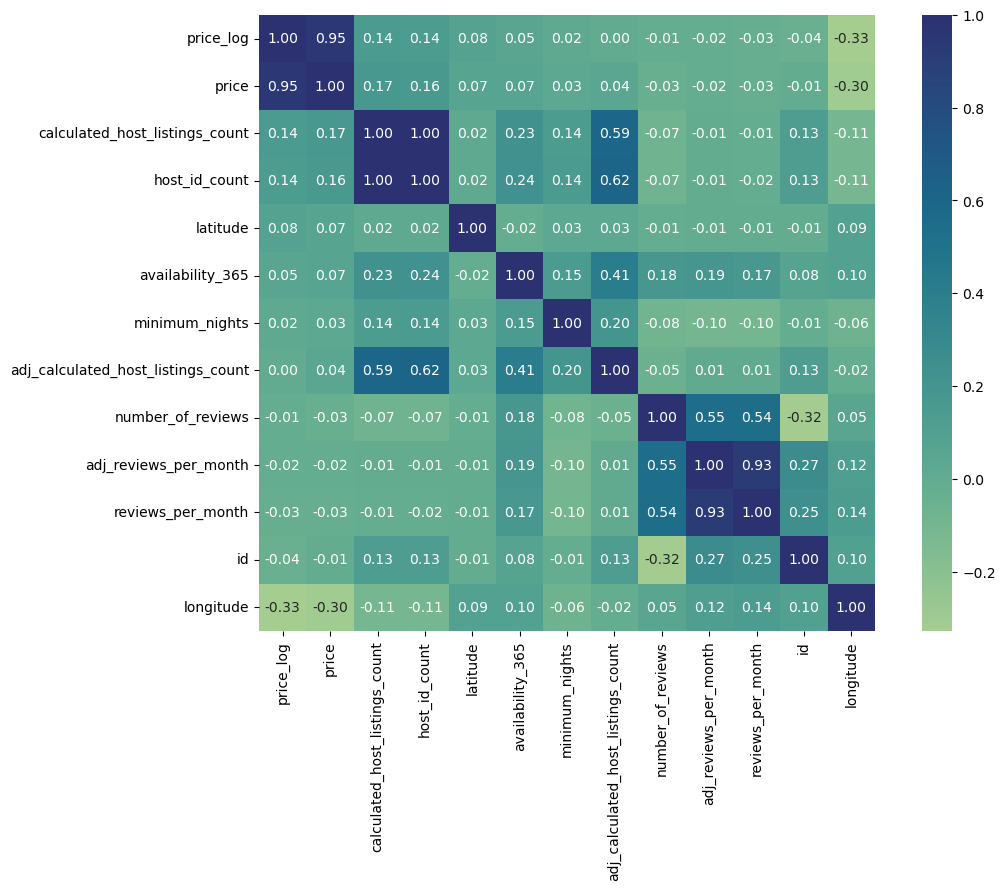

In [17]:
# create the correlation heatmap

# checking for top variables in term of correlation with price
corr=df1.corr()
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'price_log')['price_log'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

 **categorical variables**

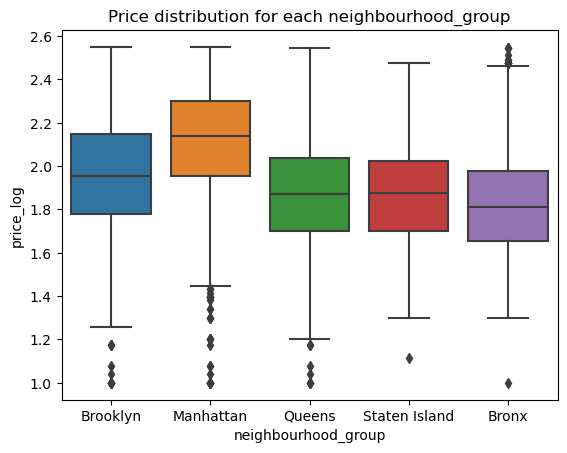

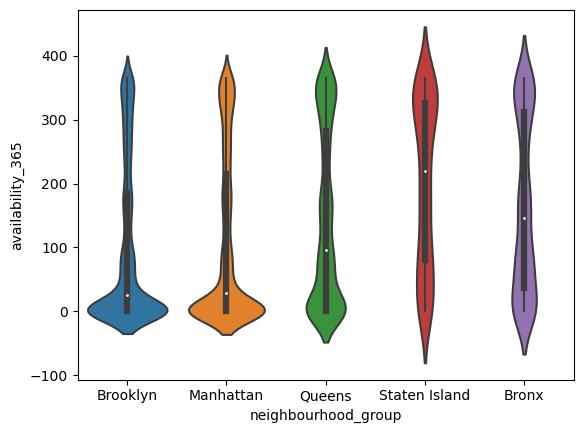

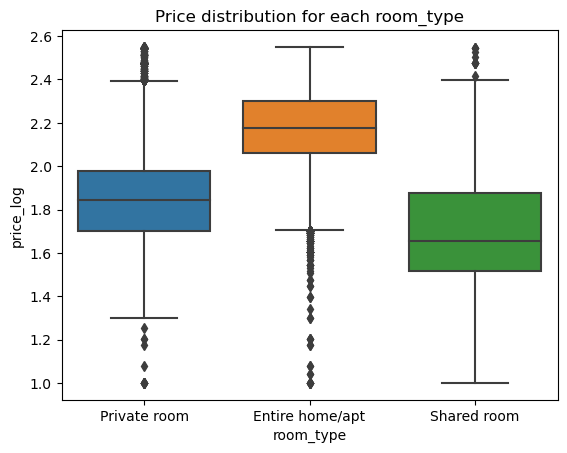

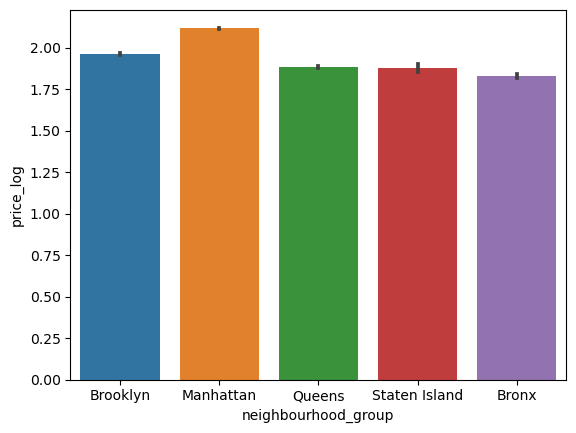

In [18]:
# check the correlation between price and every categorical feature.

# price by neighbourhood_group
ax = sns.boxplot(data=df1, x='neighbourhood_group', y='price_log')
ax.set_title('Price distribution for each neighbourhood_group')
plt.show()

ax = sns.violinplot(data=df1, x="neighbourhood_group", y="availability_365")
plt.show()
#Violin Plot shows that Staten Island has the highest mean availability value around 220-250 days compared to others

# price by room_type
ax = sns.boxplot(data=df1, x='room_type', y='price_log')
ax.set_title('Price distribution for each room_type')
plt.show()

sns.barplot(data=df1, x='neighbourhood_group', y='price_log')
plt.show()
#Result shows that Manhattan has the most expensive prices.


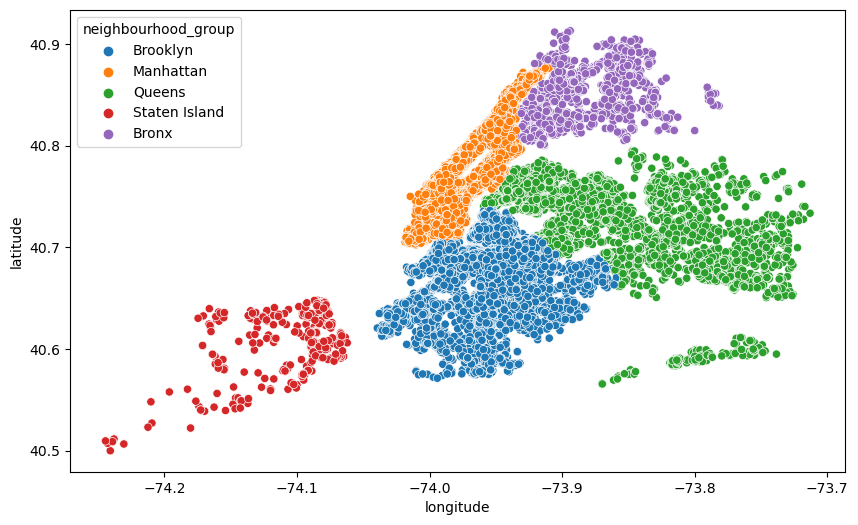

In [19]:
#Scatterplot to visualise latitude and longitude 
plt.figure(figsize=(10,6))
sns.scatterplot(data=df1,x = df1['longitude'],y= df1['latitude'],hue=df1.neighbourhood_group)
plt.ioff()
#Result shows density is high for manhattan and brooklyn

2020     9186
2019    24108
2018     5825
2017     3118
2016     2603
2015     1337
2014      189
2013       46
2012       24
2011        7
Freq: A-DEC, Name: y_last_review, dtype: int64


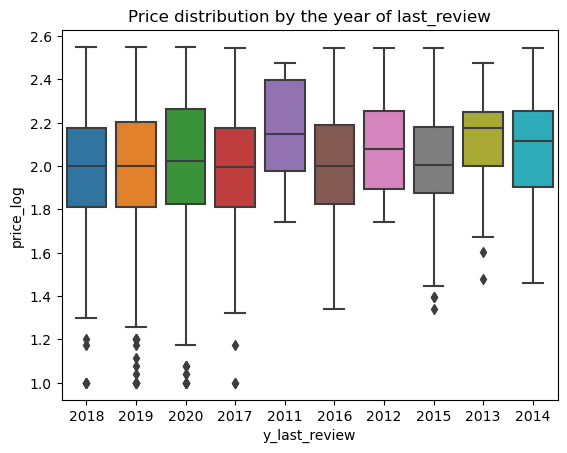

In [20]:
# add two columns containing information about last_review in a yearly or yearly+monthly basis.
# I'm not sure how much does it work.

df1['y_m_last_review'] = pd.to_datetime(df1['last_review']).dt.to_period('M')
df1['y_last_review'] = pd.to_datetime(df1['last_review']).dt.to_period('Y')
print(df1['y_last_review'].value_counts().sort_index(ascending=False))

# price by y_last_review
ax = sns.boxplot(data=df1, x='y_last_review', y='price_log')
ax.set_title('Price distribution by the year of last_review')
plt.show()


In [21]:
# add a column combining the inforamtion of neighbourhood with neighbourhood_group
df1['adj_neighbourhood'] = df1['neighbourhood_group'].str.cat(df1['neighbourhood'], sep=' ')
df1.head()

id                                              name host_id  \
0  2539                Clean & quiet apt home by the park    2787   
1  2595                             Skylit Midtown Castle    2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !    4632   
3  3831                   Cozy Entire Floor of Brownstone    4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park    7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  ...  reviews_per_month  \
0     Private room    149  ...           0.210000   
1  Entire home/apt    225  ...           0.380000   
2     Private room    150  ...           1.373221   
3  Entire home/apt     89  ...           4.640000   
4  Entire home/apt     80  ...           0.100000   

   calculated_host_listings_count availability_365  price_log  \
0                               6              365   2.173186   
1                               2              355   2.352183   
2                               1              365   2.176091   
3                               1              194   1.949390   
4                               1                0   1.903090   

   adj_calculated_host_listings_count  adj_reviews_per_month  host_id_count  \
0                                 6.0               0.210000              6   
1                                 2.0               0.380000              2   
2                                 1.0               1.373221              1   
3                                 1.0               4.350000              1   
4                                 1.0               0.100000              1   

   y_m_last_review  y_last_review      adj_neighbourhood  
0          2018-10           2018    Brooklyn Kensington  
1          2019-05           2019      Manhattan Midtown  
2          2020-01           2020       Manhattan Harlem  
3          2019-07           2019  Brooklyn Clinton Hill  
4          2018-11           2018  Manhattan East Harlem  

[5 rows x 23 columns]

In [22]:
# using ANOVA to check the correlation of categorical features and our predictive variable(price)

model = sm.OLS.from_formula('price_log ~ host_id_count', data=df1).fit()
sm.stats.anova_lm(model, typ=2)

# we can see that adj_neighbourhood is an important categorical feature to some extent cuz the F-value is 875 with 0 p-value.

sum_sq       df           F         PR(>F)
host_id_count    57.175086      1.0  886.993945  4.360822e-193
Residual       2993.558390  46441.0         NaN            NaN

In [23]:
model2 = ols('price_log ~ neighbourhood_group', data=df1).fit()
sm.stats.anova_lm(model2, typ=2)

# we can see that neighbourhood_group is a very important categorical feature cuz the F-value is very large with 0 p-value.

sum_sq       df            F  PR(>F)
neighbourhood_group   401.900593      4.0  1761.479542     0.0
Residual             2648.832883  46438.0          NaN     NaN

In [24]:
model3 = ols('price_log ~ room_type', data=df1).fit()
sm.stats.anova_lm(model3, typ=2)

# we can see that room type is a very important categorical feature cuz the F-value is very large with 0 p-value.

sum_sq       df             F  PR(>F)
room_type  1351.787012      2.0  18475.269871     0.0
Residual   1698.946464  46440.0           NaN     NaN

In [50]:
df1['y_last_review'] = df1['y_last_review'].astype(str)
df1['y_m_last_review'] = df1['y_m_last_review'].astype(str)

model4 = ols('price ~ y_last_review', data=df1).fit()
sm.stats.anova_lm(model4, typ=2)

/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_12504/1713617318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['y_last_review'] = df1['y_last_review'].astype(str)
/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_12504/1713617318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['y_m_last_review'] = df1['y_m_last_review'].astype(str)


sum_sq       df         F        PR(>F)
y_last_review  2.190271e+07      9.0  42.51319  1.430971e-76
Residual       2.797754e+09  48874.0       NaN           NaN

# Feature Selection & Modeling

In [28]:
# features to choose
selected_feature = ['neighbourhood_group','neighbourhood','latitude','longitude','number_of_reviews','room_type','minimum_nights',\
                    'reviews_per_month','calculated_host_listings_count','availability_365','host_id_count']
x_data = df1[selected_feature]
y_data = df1[['price_log']]


In [29]:
# split training & test set
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(37154, 11) (9289, 11)
(37154, 1) (9289, 1)


In [30]:
#define numerical and categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)
print(numerical_columns)
print(categorical_columns)

['latitude', 'longitude', 'number_of_reviews', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_id_count']
['neighbourhood_group', 'neighbourhood', 'room_type']


In [32]:
#define preprocessor to all selected columns
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('standard_scaler', StandardScaler(), numerical_columns)])

 **Decision Tree**

In [36]:
model = make_pipeline(preprocessor,DecisionTreeRegressor())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_orig_scale = np.power(10,y_pred)
y_test_orig_scale = np.power(10,y_test)
r2 = r2_score(y_test_orig_scale, y_pred_orig_scale)
print("r2 score:", r2)

#Perform cross-validation using the cross_val_score function
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

r2 score: 0.15351853817497318
Cross-validation R-squared scores: [0.28802518 0.30132461 0.30453409 0.29711937 0.27780492]
Mean R-squared score: 0.294
Standard deviation of R-squared scores: 0.010


 **Gradient Boosting**

In [33]:
model2 = make_pipeline(preprocessor, GradientBoostingRegressor())
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('r2 score', r2)
y_pred_orig_scale = np.power(10,y_pred)
y_test_orig_scale = np.power(10,y_test)
r2 = r2_score(y_test_orig_scale, y_pred_orig_scale)
print("r2 score after rescale:", r2)

#Perform cross-validation using the cross_val_score function
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))



/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 score 0.6273865424884797
r2 score after rescale: 0.5296557023839972


/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Cross-validation R-squared scores: [0.62671492 0.62956332 0.62892009 0.63381489 0.64002334]
Mean R-squared score: 0.632
Standard deviation of R-squared scores: 0.005


 **XGboost**

In [37]:
model3 = make_pipeline(preprocessor,xgb.XGBRegressor(objective="reg:linear", random_state=42))
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

[17:29:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
r2 score: 0.6462797003473839
[17:29:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/

 **Random Forest**

In [38]:
model4 = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=500))
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# # Perform cross-validation using the cross_val_score function
# scores = cross_val_score(model4, X_train, y_train, cv=5, scoring='r2')

# # Calculate and print the mean and standard deviation of the cross-validation scores
# print("Cross-validation R-squared scores: {}".format(scores))
# print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
# print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


r2 score: 0.6483519901702077


**CATBOOST**

In [39]:
model5 = make_pipeline(preprocessor, catboost.CatBoostRegressor())
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)


Learning rate set to 0.072484
0:	learn: 0.2462121	total: 18.9ms	remaining: 18.9s
1:	learn: 0.2372191	total: 25.9ms	remaining: 12.9s
2:	learn: 0.2290993	total: 30.1ms	remaining: 10s
3:	learn: 0.2217864	total: 34.9ms	remaining: 8.69s
4:	learn: 0.2153668	total: 39.7ms	remaining: 7.89s
5:	learn: 0.2094236	total: 44ms	remaining: 7.29s
6:	learn: 0.2042139	total: 47.7ms	remaining: 6.77s
7:	learn: 0.1994835	total: 51.9ms	remaining: 6.44s
8:	learn: 0.1953348	total: 58.6ms	remaining: 6.46s
9:	learn: 0.1915482	total: 62.2ms	remaining: 6.16s
10:	learn: 0.1882599	total: 66.2ms	remaining: 5.95s
11:	learn: 0.1852267	total: 71.4ms	remaining: 5.88s
12:	learn: 0.1824983	total: 75.3ms	remaining: 5.71s
13:	learn: 0.1801029	total: 78.9ms	remaining: 5.56s
14:	learn: 0.1779941	total: 82.8ms	remaining: 5.44s
15:	learn: 0.1760868	total: 91.7ms	remaining: 5.64s
16:	learn: 0.1743654	total: 95.7ms	remaining: 5.54s
17:	learn: 0.1728306	total: 99.7ms	remaining: 5.44s
18:	learn: 0.1714476	total: 106ms	remaining: 5.4

**Hyperparameter Tuning**

In [46]:
# implement BayesSearch method on catboost model and get the best model parameters and result.

# Define the search space
# define the hyperparameter search space
search_spaces = {
    'catboostregressor__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'catboostregressor__depth': Integer(2, 10),
    'catboostregressor__l2_leaf_reg': Integer(0, 10),
    'catboostregressor__iterations': Integer(50, 500),
    'catboostregressor__rsm': Real(0.1, 1.0, prior='uniform'),
    'catboostregressor__random_strength': Real(0.1, 10, prior='log-uniform'),
    'catboostregressor__bagging_temperature': Real(0.0, 1.0),
    'catboostregressor__border_count': Integer(1, 255)
}

# define the Bayesian search
bayes_cv_tuner = BayesSearchCV(
    estimator=model5,
    search_spaces=search_spaces,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    n_iter=50,
    verbose=0,
    refit=True,
    random_state=42
)

# run the search
bayes_cv_tuner.fit(X_train, y_train)

# print the best hyperparameters and score
print(bayes_cv_tuner.best_params_)
print(bayes_cv_tuner.best_score_)

0:	learn: 69.4672316	total: 348ms	remaining: 1m 6s
0:	learn: 69.2496085	total: 374ms	remaining: 1m 11s
0:	learn: 69.6760664	total: 196ms	remaining: 37.4s
0:	learn: 69.6646961	total: 367ms	remaining: 1m 10s
1:	learn: 67.3473254	total: 393ms	remaining: 37.3s
1:	learn: 67.1375184	total: 413ms	remaining: 39.2s
1:	learn: 67.5456559	total: 409ms	remaining: 38.8s
1:	learn: 67.5548873	total: 262ms	remaining: 24.9s
2:	learn: 65.4532861	total: 449ms	remaining: 28.3s
2:	learn: 65.6680790	total: 463ms	remaining: 29.2s
2:	learn: 65.2621134	total: 474ms	remaining: 29.9s
2:	learn: 65.6713841	total: 320ms	remaining: 20.2s
3:	learn: 63.7164374	total: 541ms	remaining: 25.4s
3:	learn: 63.9231434	total: 386ms	remaining: 18.1s
4:	learn: 62.3342040	total: 426ms	remaining: 15.9s
3:	learn: 63.5314321	total: 640ms	remaining: 30.1s
3:	learn: 63.9501053	total: 634ms	remaining: 29.8s
4:	learn: 61.9681986	total: 709ms	remaining: 26.5s
4:	learn: 62.1260670	total: 702ms	remaining: 26.3s
4:	learn: 62.3637136	total: 7

KeyboardInterrupt: 